# EDA Tablas Meta
---
tras nuestro analisis a las distintas tablas de datos, nos dimos cuenta de la similaridad en estructura de cada una de las tablas, por lo que crearemos un EDA modelo donde respetaremos los pasos para automatizar este proceso.

### Importacion de librerias

In [1]:
import pandas as pd #utilizaremos pandas para el mejor manejo de tablas
import numpy as np #utilizaremos numpy para un mejor tratamiento de los datos
import matplotlib.pyplot as plt
import seaborn as sns # matplotlib y seaborn seran usados para graficar
from pyspark.sql import SparkSession #pyspark lo usaremos como opcion al gran requerimiento de procesamiento de datos

# Crea una sesión de Spark
spark = SparkSession.builder \
    .appName("MiAplicacionSpark") \
    .getOrCreate()
#importamos las funciones sql de pyspark para el manejo de columnas y valores
from pyspark.sql.functions import col, sum, when, size, length, to_date, from_unixtime, year, regexp_replace, avg, lit, coalesce, array, concat_ws, isnull, explode
from pyspark.ml.feature import Imputer

## Paso 1: Extraemos archivo.
---

In [2]:
df = spark.read.json('../datasets/meta_Digital_Music.json', encoding='UTF-8')
#observamos la cantidad de filas
df.count()

74347

In [3]:
df.show()

+--------------------+--------------------+----------+--------------------+--------+----+--------------------+-------+-------+---+--------------------+--------------------+--------------------+---------+--------------------+------------+-----+-----+--------------------+
|            also_buy|           also_view|      asin|               brand|category|date|         description|details|feature|fit|            imageURL|     imageURLHighRes|            main_cat|    price|                rank|similar_item|tech1|tech2|               title|
+--------------------+--------------------+----------+--------------------+--------+----+--------------------+-------+-------+---+--------------------+--------------------+--------------------+---------+--------------------+------------+-----+-----+--------------------+
|[B000002UEN, B000...|[B000002UEN, B000...|0001377647| John Michael Talbot|      []|    |                  []|   null|     []|   |                  []|                  []|<img src="https

## Paso 2: Manejo de Duplicados.
---

In [4]:
num_filas_duplicadas = df.count() - df.dropDuplicates().count()

# Imprime el número de filas duplicadas
print("Número de filas duplicadas:", num_filas_duplicadas)
print(f"Porcentaje de filas duplicadas: {num_filas_duplicadas / df.count()}")
df = df.dropDuplicates()

Número de filas duplicadas: 8334
Porcentaje de filas duplicadas: 0.11209598235302029


Eliminamos los duplicados ya que se repiten los valores en todas las columnas el mismo valor, con valores como also_buy que implican que es exactamente lo mismo

## Paso 3: Manejo de Faltantes.

Primero revisemos los valores faltantes

In [5]:
# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

print(f"cantidad de filas: {df.count()}")
# Muestra el resultado
conteo_de_nulos_por_columna.show()

cantidad de filas: 66013
+--------+---------+----+-----+--------+----+-----------+-------+-------+---+--------+---------------+--------+-----+----+------------+-----+-----+-----+
|also_buy|also_view|asin|brand|category|date|description|details|feature|fit|imageURL|imageURLHighRes|main_cat|price|rank|similar_item|tech1|tech2|title|
+--------+---------+----+-----+--------+----+-----------+-------+-------+---+--------+---------------+--------+-----+----+------------+-----+-----+-----+
|       0|        0|   0|    0|       0|   0|          0|    534|      0|  0|       0|              0|       0|    0|   0|           0|    0|    0|    0|
+--------+---------+----+-----+--------+----+-----------+-------+-------+---+--------+---------------+--------+-----+----+------------+-----+-----+-----+



Podemos observar que la mayoria de las columnas no poseen faltantes, pero en un breve vistaso a nuestra tabla sabemos que esto no es cierto, por lo que convertiremos las filas vacias de todas las columnas de tipo array y todas las columnas de tipo string a nulos

In [6]:
columnas_array_a_verificar = ["also_buy", "also_view", "category", "description", "feature"]

# Verifica si las columnas string están vacías y las marca como nulas si es necesario
for columna in columnas_array_a_verificar:
    df = df.withColumn(columna, when(size(col(columna)) > 0, col(columna)).otherwise(None))

columnas_string_a_verificar = ["asin", "title", "price", "rank", "brand", 'date', 'main_cat', 'similar_item', 'fit']

# Verifica si las columnas string están vacías y las marca como nulas si es necesario
for columna in columnas_string_a_verificar:
    df = df.withColumn(columna, when((length(col(columna)) == 0) | (col(columna).isNull()), None).otherwise(col(columna)))


In [7]:
# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

print(df.count())
# Muestra el resultado
conteo_de_nulos_por_columna.show()

66013
+--------+---------+----+-----+--------+-----+-----------+-------+-------+-----+--------+---------------+--------+-----+----+------------+-----+-----+-----+
|also_buy|also_view|asin|brand|category| date|description|details|feature|  fit|imageURL|imageURLHighRes|main_cat|price|rank|similar_item|tech1|tech2|title|
+--------+---------+----+-----+--------+-----+-----------+-------+-------+-----+--------+---------------+--------+-----+----+------------+-----+-----+-----+
|   57580|    53714|   0|13325|   66006|66008|      32979|    534|  65924|66013|       0|              0|       0|25902|   0|       66013|    0|    0|  513|
+--------+---------+----+-----+--------+-----+-----------+-------+-------+-----+--------+---------------+--------+-----+----+------------+-----+-----+-----+



In [8]:
# Calcula el total de filas en el DataFrame
total_de_filas = df.count()

# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Calcula el porcentaje de nulos respecto al total de filas para cada columna
porcentaje_de_nulos_por_columna = conteo_de_nulos_por_columna.select([((col(c) / total_de_filas) * 100).alias(c) for c in df.columns])

# Muestra el resultado
porcentaje_de_nulos_por_columna.show()

+-----------------+-----------------+----+----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----+--------+---------------+--------+------------------+----+------------+-----+-----+------------------+
|         also_buy|        also_view|asin|           brand|         category|             date|      description|           details|          feature|  fit|imageURL|imageURLHighRes|main_cat|             price|rank|similar_item|tech1|tech2|             title|
+-----------------+-----------------+----+----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----+--------+---------------+--------+------------------+----+------------+-----+-----+------------------+
|87.22524351264144|81.36882129277566| 0.0|20.1854180237226|99.98939602805508|99.99242573432505|49.95834153878781|0.8089315740838926|99.86517807098602|100.0|     0.0|            0.0|     0.0|39.237725902473755| 0.0|       10

Viendo nuestros reales valores faltantes tomamos la decision de hacer algo con esto, esto haremos con las siguiente columnas:
- also_buy: conservamos la columna y convertiremos los faltantes en N/D ya que la poca informacion que tiene es relevante
- also_view: similar a also_buy
- asin: indica el id de cada metadata por lo que la conservamos
- brand: conservamos y transformamos faltantes en N/D ya que es relevante
- category: eliminamos la columna por un 99% de valores nulos
- date: eliminamos por casi un 100% de valores faltantes
- description: reemplazamos faltantes por N/D por su posible uso
- details: trataremos esta columna mas adelante ya que extraeremos un dataframe de esta, pero eliminamos los valores nulos
- feature: similar a category y date
- fit: se elimina por 100% de valores faltantes
- imageURL: no es relevante por lo que eliminamos
- imageURLHighRes: similar a imageURL
- main_cat: se conserva ya que indica la categoria.
- price: se conserva y se trataran los faltantes tras un posterior analisis
- rank: se conserva por su relevancia en el ranking 
- similar_item: similar a fit, se elimina
- tech1 y tech2: si bien no figuran faltantes, tampoco son relevantes.
- title: se eliminaran los valores nulos unicamente

In [9]:
# Lista de nombres de columnas que deseas eliminar
columnas_a_eliminar = ["imageURL", "imageUrlHighRes", "tech1", 'tech2', 'category', 'date', 'feature', 'fit', 'similar_item']

# Elimina las columnas especificadas
df = df.drop(*columnas_a_eliminar)


# eliminamos los valores nulos
df = df.na.drop(subset=['title'])
df = df.na.drop(subset=['details'])

In [10]:
df.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Apparel: string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio Cassette: string (nullable = true)
 |    |-- Blu-ray Audio: string (nullable = true)
 |    |-- DVD: string (nullable = true)
 |    |-- DVD Audio: string (nullable = true)
 |    |-- Label:: string (nullable = true)
 |    |-- MP3 Music: string (nullable = true)
 |    |-- Note on Boxed Sets:: string

Columnas a transformar: 
- price: imputar con moda
- rank: dejar solo rank
- main_cat: dejar solo categoria
- brand: imputar faltantes con N/D
- also_buy: imputar faltantes con N/D
- also_view: imputar faltantes con N/D
- description: imputar faltantes con N/D

In [11]:
df = df.withColumn('main_cat', lit('Digital Music'))

In [12]:
# Utiliza regexp_replace para eliminar todos los caracteres que no sean números
df = df.withColumn('rank', regexp_replace(df['rank'], '[^0-9]', ''))
df = df.withColumn("rank", when(df["rank"] == '', 'N/D').otherwise(df["rank"]))
df = df.fillna({'brand': 'N/D'})

In [13]:
df = df.withColumn("also_buy", concat_ws(", ", col("also_buy")))
df = df.withColumn("also_view", concat_ws(", ", col("also_view")))
df = df.withColumn("description", concat_ws(", ", col("description")))

df = df.withColumn("also_buy", when(col("also_buy") == '', 'N/D').otherwise(col("also_buy")))
df = df.withColumn("also_view", when(col("also_view") == '', 'N/D').otherwise(col("also_view")))
df = df.withColumn("description", when(col("description") == '', 'N/D').otherwise(col("description")))


df.show()


+--------+--------------------+----------+-------------------+--------------------+--------------------+-------------+------+-------+--------------------+
|also_buy|           also_view|      asin|              brand|         description|             details|     main_cat| price|   rank|               title|
+--------+--------------------+----------+-------------------+--------------------+--------------------+-------------+------+-------+--------------------+
|     N/D|                 N/D|B000003SDF|    Richard H. Kirk|                 N/D|{null, null, B000...|Digital Music|  null|1255550|Agents With False...|
|     N/D|                 N/D|B000006XV0|           Creation|                 N/D|{null, null, B000...|Digital Music|$12.50|1761232|       Lay the Ghost|
|     N/D|                 N/D|B00000AQFD|Wildecker Herzbuben|                 N/D|{null, null, B000...|Digital Music| $1.72|1157548|Ist das nicht him...|
|     N/D|                 N/D|B00000AU08|           Skeptics|        

In [14]:
df = df.withColumn("price", regexp_replace(col("price"), "\\$", "").cast("float"))
# Convierte el DataFrame de PySpark a un DataFrame de Pandas para usar con Seaborn
# Calcula estadísticas descriptivas de la columna 'price'
summary = df.select("price").describe()
summary.show()

# Calcula el rango intercuartil (IQR) de la columna 'price'
q1 = df.approxQuantile("price", [0.25], 0.01)[0]
q3 = df.approxQuantile("price", [0.75], 0.01)[0]
iqr = q3 - q1

# Define los límites inferior y superior para detectar outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtra los outliers en la columna 'price'
outliers = df.filter((df["price"] < lower_bound) | (df["price"] > upper_bound))
outliers.count()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             38544|
|   mean|22.402378289778913|
| stddev|36.057771314012754|
|    min|              0.01|
|    max|            999.99|
+-------+------------------+



3190

Podemos observar un poco la naturaleza de los precios, vemos la cantidad de outliers generados en estos precios. Para entender un poco mejor hagamos un boxplot

c:\Users\niko\Desktop\sistema_recomendacion_amazon\venv_sistema_amazon\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


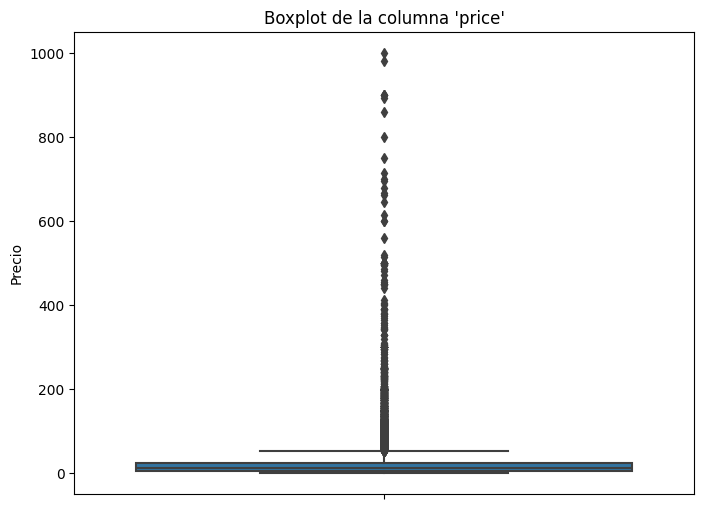

In [15]:
data_pd = df.select("price").toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(data=data_pd, y="price")
plt.title("Boxplot de la columna 'price'")
plt.ylabel("Precio")
plt.show()

Parece que hay productos de hasta 999 dolares, creemos que esto es posible, ya que puede tratarse de discos de oro o objetos firmados por famosos, por lo que consideramos que la distribucion esta bien y los outliers son considerados como tal por la gran cantidad de volumen que tenemos entre el dolar y los 50 dolares. Por lo que tambien procedemos a imputar los valores faltantes en este rango de precios teniendo en cuenta la moda.

In [16]:
# Calcula la moda de la columna 'price'
mode_price = df.groupBy("price").count().orderBy("count", ascending=False).first()["price"]

# Crea un imputador para reemplazar los valores nulos en la columna 'price' con la moda
imputer = Imputer(strategy="mode", inputCol="price", outputCol="price")

# Ajusta el imputador al conjunto de datos y reemplaza los valores nulos
model = imputer.fit(df)
df = model.transform(df)

# Muestra el DataFrame con los valores nulos reemplazados por la moda
df.show()


+--------+--------------------+----------+-------------------+--------------------+--------------------+-------------+-----+-------+--------------------+
|also_buy|           also_view|      asin|              brand|         description|             details|     main_cat|price|   rank|               title|
+--------+--------------------+----------+-------------------+--------------------+--------------------+-------------+-----+-------+--------------------+
|     N/D|                 N/D|B000003SDF|    Richard H. Kirk|                 N/D|{null, null, B000...|Digital Music| 9.99|1255550|Agents With False...|
|     N/D|                 N/D|B000006XV0|           Creation|                 N/D|{null, null, B000...|Digital Music| 12.5|1761232|       Lay the Ghost|
|     N/D|                 N/D|B00000AQFD|Wildecker Herzbuben|                 N/D|{null, null, B000...|Digital Music| 1.72|1157548|Ist das nicht him...|
|     N/D|                 N/D|B00000AU08|           Skeptics|              

# Analisis de la columna 'details'

In [17]:
df.printSchema()

root
 |-- also_buy: string (nullable = false)
 |-- also_view: string (nullable = false)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = false)
 |-- description: string (nullable = false)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Apparel: string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio Cassette: string (nullable = true)
 |    |-- Blu-ray Audio: string (nullable = true)
 |    |-- DVD: string (nullable = true)
 |    |-- DVD Audio: string (nullable = true)
 |    |-- Label:: string (nullable = true)
 |    |-- MP3 Music: string (nullable = true)
 |    |-- Note on Boxed Sets:: string (nullable = true)
 |    |-- Number of Discs:: string (nullable = true)
 |    |-- Original Release Date:: string (nullable = true)
 |    

In [19]:
df_details = df.select(
    "details.*"
)

In [20]:
df_details.show()

+-------------------------+--------------------------------+----------+------+-------+-------------------+--------------+-------------+----+---------+-----------------+---------+-------------------+----------------+----------------------+------------+---------+-----------+----------------+----+-----+-----------+
|\n    Item Weight: \n    |\n    Product Dimensions: \n    |     ASIN:|ASIN: |Apparel|           Audio CD|Audio Cassette|Blu-ray Audio| DVD|DVD Audio|           Label:|MP3 Music|Note on Boxed Sets:|Number of Discs:|Original Release Date:|Please Note:|Run Time:|SPARS Code:|Shipping Weight:|UPC:|Vinyl|Vinyl Bound|
+-------------------------+--------------------------------+----------+------+-------+-------------------+--------------+-------------+----+---------+-----------------+---------+-------------------+----------------+----------------------+------------+---------+-----------+----------------+----+-----+-----------+
|                     null|                            nul

Podemos observar la gran cantidad de valores nulos que poseemos en la columna details, chequeemos un poco mas a fondo para ver la relevancia de esta columna

In [22]:
# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df_details.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_details.columns])

print(df_details.count())
# Muestra el resultado
conteo_de_nulos_por_columna.show()

64966
+-------------------------+--------------------------------+-----+------+-------+--------+--------------+-------------+-----+---------+------+---------+-------------------+----------------+----------------------+------------+---------+-----------+----------------+-----+-----+-----------+
|\n    Item Weight: \n    |\n    Product Dimensions: \n    |ASIN:|ASIN: |Apparel|Audio CD|Audio Cassette|Blu-ray Audio|  DVD|DVD Audio|Label:|MP3 Music|Note on Boxed Sets:|Number of Discs:|Original Release Date:|Please Note:|Run Time:|SPARS Code:|Shipping Weight:| UPC:|Vinyl|Vinyl Bound|
+-------------------------+--------------------------------+-----+------+-------+--------+--------------+-------------+-----+---------+------+---------+-------------------+----------------+----------------------+------------+---------+-----------+----------------+-----+-----+-----------+
|                    64960|                           64942| 1004| 64965|  64964|   55160|         64940|        64952|64965|  

In [24]:
# Calcula el total de filas en el DataFrame
total_de_filas = df_details.count()

# Calcula la cantidad de nulos por columna
conteo_de_nulos_por_columna = df_details.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_details.columns])

# Calcula el porcentaje de nulos respecto al total de filas para cada columna
porcentaje_de_nulos_por_columna = conteo_de_nulos_por_columna.select([((col(c) / total_de_filas) * 100).alias(c) for c in df_details.columns])

# Muestra el resultado
porcentaje_de_nulos_por_columna.show()

+-------------------------+--------------------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+------------------+----------------------+-----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+
|\n    Item Weight: \n    |\n    Product Dimensions: \n    |             ASIN:|           ASIN: |          Apparel|         Audio CD|   Audio Cassette|    Blu-ray Audio|              DVD|        DVD Audio|           Label:|        MP3 Music|Note on Boxed Sets:|  Number of Discs:|Original Release Date:|     Please Note:|       Run Time:|     SPARS Code:| Shipping Weight:|             UPC:|            Vinyl|      Vinyl Bound|
+-------------------------+--------------------------------+------------------+-----------------+-----------------+-----------------+-----------

Hay una gran cantidad de valores nulos, dejando solo para destacar columnas como label y number of discs, con poco menos del 50% de valores nulos.